# Recurrent Neural Network
Implementation adapted from Pytorch tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

Recurrent neural networks are the simplest architecture that keeps track of a hidden state as a type of memory. It carries this information across time steps to "remember" past inputs. This hidden state is used to influence the output given an input for the current timestep.

There are three weights, input weight, hidden weight, and output weight. These weights remain the same and are reused across steps.

Let's implement a very basic character level RNN to classify names by language.

In [1]:
# Import necessary packages
import requests
import io
import zipfile
import os
import unicodedata
import string
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import math
import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random

# Loading Data
The Pytorch tutorial provides a dataset which you can download. However, in this notebook, just read the data into memory directly.

In [2]:
# Define all letters in ascii plus some additional characters
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def read_names_dataset():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    url = 'https://download.pytorch.org/tutorial/data.zip'
    r = requests.get(url)
    with io.BytesIO(r.content) as zip_bytes:
        with zipfile.ZipFile(zip_bytes) as f:
            zip_contents = f.namelist()
            
            for filename in zip_contents:
                # Skip over irrelevant files and folders
                if 'data/names' not in filename or '.' not in filename:
                    continue
                category = os.path.splitext(os.path.basename(filename))[0]
                all_categories.append(category)
                lines = f.read(filename).decode('utf-8').strip().split('\n')
                lines = [unicodeToAscii(line) for line in lines]
                category_lines[category] = lines
    return all_categories, category_lines

In [3]:
all_categories, category_lines = read_names_dataset()
n_categories = len(all_categories)

In [4]:
print(all_categories)
print(category_lines['Italian'][:5])

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Now that the data is loaded in, define a few helper functions to convert between character and numerical representation. Also define a function to return the most likely language given probabilities output from the model.

In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

Finally, define functions to randomly sample data from the dataset. This will be useful when querying data during training.

**Note:** The way the data is being sampled is important. The code below randomly samples a language and then randomly chooses a name from that language. This is different from just randomly sampling a name from the set of all names. Randomly sampling a name from the set of all names would result in training heavily on over represented languages while not learning enough from languages with fewer names in the dataset.

In [6]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

# Defining the Model

Now we define the RNN model. For a particular step t, the input is multiplied by an input weight:

$$
h^{(t)} = b + W_x^{(t)}X^{(t)} + W_h^{(t)}h^{(t-1)}
$$

$$
z^{(t)} = c + W_o^{(t)}h^{(t)}
$$

$$
o^{(t)} = g(z^{(t)})
$$

where $X^{(t)}$ is the input at time t and $h^{(t-1)}$ and $h^{(t)}$ are hidden states at steps t-1 and t, respectively,

$W_x^{(t)}$, $W_h^{(t)}$, and $W_o^{(t)}$ are the model weights that are multiplied with input, previous hidden state, and current hidden state, respectively,

$b$ and $c$ are additional bias terms,

and $g$ is a nonlinear activation function (ReLU, Tanh, etc.)

In the below model definition, these same functions are implemented but a shorthand is used where self.i2h is the weights $W_x^{(t)}$ and $W_h^{(t)}$ concatenated along the second dimension. This allows calculation of $h^{(t)}$ using only one matrix multiplication instead of using two separate multiplications for each of the weights. But this is still implementing the same function as written above.

Also, the bias terms are not explicitly calculated since there are parameters of the nn.Linear weights. For the activation function, the softmax function is used.

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [8]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


# Training

To train the model, define a criterion function to calculate the loss. NLLLoss is used here.

A train function is also defined where it takes a single name and iterates over each of the characters in the name, passing the character as input to the model as well as the previous hidden state. After all characters are passed to the model, the loss is calculated using the final output and target category and the gradients are calculated with loss.backward(). Then the gradients are manually added to the weights. **Note:** this could have also been simplified by using an optimizer to update weights automatically.

In [9]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Finally, run the training process for n_iters iterations. Keep track of losses for plotting.

In [10]:
n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.8022 Sobol / Irish ✗ (Polish)
10000 10% (0m 10s) 1.3326 Raimondi / Polish ✗ (Italian)
15000 15% (0m 15s) 0.0761 Geracimos / Greek ✓
20000 20% (0m 20s) 3.3109 De luca / Portuguese ✗ (Italian)
25000 25% (0m 25s) 0.8365 Delgado / Portuguese ✓
30000 30% (0m 30s) 1.0102 Vuu / Chinese ✗ (Vietnamese)
35000 35% (0m 36s) 2.7988 Duarte / French ✗ (Portuguese)
40000 40% (0m 41s) 1.8141 Abl / German ✗ (Czech)
45000 45% (0m 46s) 0.5801 Bumgarner / German ✓
50000 50% (0m 51s) 0.2386 Chou / Korean ✓
55000 55% (0m 56s) 0.4407 Higuchi / Japanese ✓
60000 60% (1m 1s) 1.1494 Renaud / French ✓
65000 65% (1m 7s) 0.9454 Marshall / Scottish ✓
70000 70% (1m 12s) 1.3167 Sanda / Japanese ✓
75000 75% (1m 17s) 1.7243 Rocco / Portuguese ✗ (Italian)
80000 80% (1m 22s) 1.6859 Gilfillan / Dutch ✗ (English)
85000 85% (1m 27s) 0.0821 Williamson / Scottish ✓
90000 90% (1m 32s) 0.3264 Tassioglou / Greek ✓
95000 95% (1m 37s) 0.2757 Morishita / Japanese ✓
100000 100% (1m 43s) 0.4924 Xuan / Chinese ✓


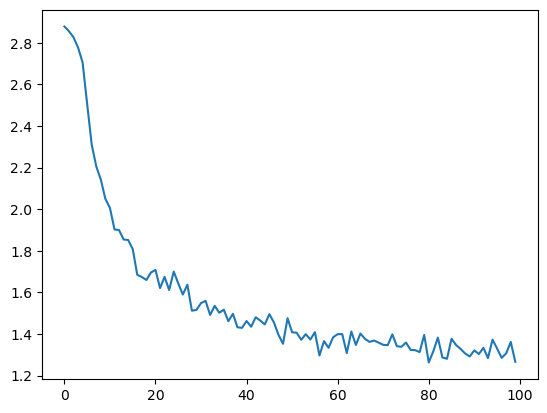

In [11]:
plt.figure()
plt.plot(all_losses)

# Evaluation

The model can be evaluated by creating a confusion matrix. The training set wasn't split into a validation set for simplicity. Randomly sample n_confusion samples from the training set and plot the guesses in the confusion matrix.

C:\Users\shrey\AppData\Local\Temp\ipykernel_182992\3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\shrey\AppData\Local\Temp\ipykernel_182992\3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


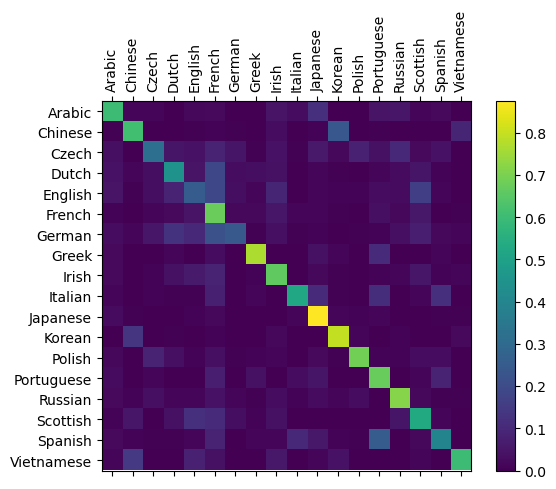

In [12]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Most of the names are classified correctly as seen from the bright diagonal. There are a few dimmer squares off the diagonal representing misclassified names.

A predict function is optionally defined below to easily test out other names that are not in the original dataset.

In [14]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.80) Russian
(-1.05) Czech
(-1.99) English

> Jackson
(-0.15) Scottish
(-2.32) English
(-4.31) Dutch

> Satoshi
(-0.28) Japanese
(-2.11) Arabic
(-3.29) Italian
